# CIFARTile


---



# Load the data

In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.0 MB/s eta 0:00:00


In [ ]:
# Load the library
from google.colab import drive
import os
import random
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow
import keras_tuner
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D
from keras_tuner import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/ColabNotebooks/Notebooks/PGT/CSC8635_MachineLearning/Assignments/CIFARTile/Dataset"

# Train
train_X = np.load(os.path.join(path, "train/train_x.npy"), allow_pickle=True)
train_y = np.load(os.path.join(path, "train/train_y.npy"), allow_pickle=True)
# Validate
validate_X = np.load(os.path.join(path, "validate/valid_x.npy"), allow_pickle=True)
validate_y = np.load(os.path.join(path, "validate/valid_y.npy"), allow_pickle=True)
# Test
test_X = np.load(os.path.join(path, "test/test_x.npy"), allow_pickle=True)
test_y = np.load(os.path.join(path, "test/test_y.npy"), allow_pickle=True)

Mounted at /content/drive


# Explore the data

## Check the shape of data

In [ ]:
print('Train dataset: x=%s, y=%s\n' % (train_X.shape, train_y.shape))
print('Validate dataset: x=%s, y=%s\n' % (validate_X.shape, validate_y.shape))
print('Test dataset: x=%s, y=%s' % (test_X.shape, test_y.shape))

Train dataset: x=(45000, 3, 64, 64), y=(45000,)

Validate dataset: x=(15000, 3, 64, 64), y=(15000,)

Test dataset: x=(10000, 3, 64, 64), y=(10000,)


## Check the classes in each dataset

* Make sure all **train**, **validate** and **test** dataset contain every classes

In [ ]:
print('Train dataset: class =', np.unique(train_y))
print('Validate dataset: class =', np.unique(validate_y))
print('Test dataset: class =', np.unique(test_y))

Train dataset: class = [0 1 2 3]
Validate dataset: class = [0 1 2 3]
Test dataset: class = [0 1 2 3]


* Check whether each class is distributed evenly

In [ ]:
def count_class(dataset):
  unique, counts = np.unique(dataset, return_counts=True)
  return dict(zip(unique, counts))

print('Train dataset:', count_class(train_y))
print('Validate dataset:', count_class(validate_y))
print('Test dataset:', count_class(test_y))

Train dataset: {0: 11359, 1: 11250, 2: 11264, 3: 11127}
Validate dataset: {0: 3764, 1: 3714, 2: 3741, 3: 3781}
Test dataset: {0: 2443, 1: 2602, 2: 2473, 3: 2482}


* Visualise the distribution of classes for each dataset

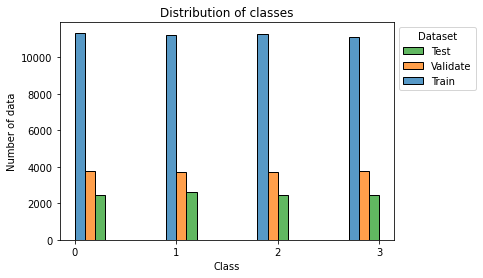

In [ ]:
plt.figure()
hist = sns.histplot([train_y, validate_y, test_y], multiple='dodge', binwidth=0.3)

plt.legend(title='Dataset', labels=['Test', 'Validate', 'Train'])
sns.move_legend(hist, "upper left", bbox_to_anchor=(1, 1))
plt.xticks([0,1,2,3],['0','1','2','3'])

plt.xlabel('Class')
plt.ylabel('Number of data')
plt.title('Distribution of classes')
plt.show(hist)

## Show the random image

In [ ]:
# Functions for plotting data image
def normalise_image(arr):
    return (arr - arr.min())/(arr.max()-arr.min())

def remove_ax_ticks(ax):
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)

def show_image(x, y):
    fig = plt.figure()
    main_ax = fig.add_subplot()
    fig.suptitle('Label: '+ str(y))
    main_ax.imshow(normalise_image(np.moveaxis(x, 0, -1)))
    remove_ax_ticks(main_ax)

    plt.show()

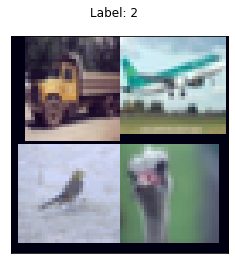

In [ ]:
count = train_X.shape[0]

ri = random.randrange(count)
show_image(train_X[ri], train_y[ri])

Here, the label value is calculated by subtracting 1 from the total number of unique classes.

# Preprocessing

## Normalisation on image

* Check the pixel values

In [ ]:
print('Train min=%.3f, max=%.3f' % (train_X.min(), train_X.max()))
print('Validate min=%.3f, max=%.3f' % (validate_X.min(), validate_X.max()))
print('Test min=%.3f, max=%.3f' % (test_X.min(), test_X.max()))

Train min=-1.989, max=2.127
Validate min=-1.989, max=2.127
Test min=-1.989, max=2.127


* Scale images to the [0, 1] range

In [ ]:
train_X = (train_X.astype("float32") - train_X.min()) / (train_X.max() - train_X.min())
validate_X = (validate_X.astype("float32") - validate_X.min()) / (validate_X.max() - validate_X.min())
test_X = (test_X.astype("float32") - test_X.min()) / (test_X.max() - test_X.min())

In [ ]:
print('Train min=%.3f, max=%.3f' % (train_X.min(), train_X.max()))
print('Validate min=%.3f, max=%.3f' % (validate_X.min(), validate_X.max()))
print('Test min=%.3f, max=%.3f' % (test_X.min(), test_X.max()))

Train min=0.000, max=1.000
Validate min=0.000, max=1.000
Test min=0.000, max=1.000


* Distribution of pixel values

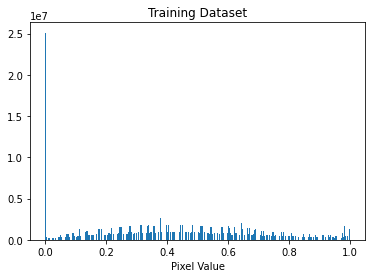

In [ ]:
plt.figure()
plt.hist(train_X.ravel(), bins='auto')

plt.xlabel('Pixel Value')
plt.title('Training Dataset')
plt.show()

## Scaling

In [ ]:
print('Train dataset: x=%s, y=%s\n' % (train_X.shape, train_y.shape))
print('Validate dataset: x=%s, y=%s\n' % (validate_X.shape, validate_y.shape))
print('Test dataset: x=%s, y=%s' % (test_X.shape, test_y.shape))

Train dataset: x=(45000, 3, 64, 64), y=(45000,)

Validate dataset: x=(15000, 3, 64, 64), y=(15000,)

Test dataset: x=(10000, 3, 64, 64), y=(10000,)


In [ ]:
# Convert the data structure
train_X = np.rollaxis(train_X, 1, 4)
validate_X = np.rollaxis(validate_X, 1, 4)
test_X = np.rollaxis(test_X, 1, 4)

# Resize image as 32
# train_X = tensorflow.image.resize(train_X, [32,32])
# validate_X = tensorflow.image.resize(validate_X, [32,32])
# test_X = tensorflow.image.resize(test_X, [32,32])

In [ ]:
print('Train dataset: x=%s, y=%s\n' % (train_X.shape, train_y.shape))
print('Validate dataset: x=%s, y=%s\n' % (validate_X.shape, validate_y.shape))
print('Test dataset: x=%s, y=%s' % (test_X.shape, test_y.shape))

Train dataset: x=(45000, 64, 64, 3), y=(45000,)

Validate dataset: x=(15000, 64, 64, 3), y=(15000,)

Test dataset: x=(10000, 64, 64, 3), y=(10000,)


## One-hot encoding

In [ ]:
num_classes = 4   # 0 to 3

train_y = keras.utils.to_categorical(train_y, num_classes)
validate_y = keras.utils.to_categorical(validate_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

In [ ]:
print('Train dataset: x=%s, y=%s\n' % (train_X.shape, train_y.shape))
print('Validate dataset: x=%s, y=%s\n' % (validate_X.shape, validate_y.shape))
print('Test dataset: x=%s, y=%s' % (test_X.shape, test_y.shape))

Train dataset: x=(45000, 64, 64, 3), y=(45000, 4)

Validate dataset: x=(15000, 64, 64, 3), y=(15000, 4)

Test dataset: x=(10000, 64, 64, 3), y=(10000, 4)


## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(shear_range=9, horizontal_flip=True, vertical_flip=True, channel_shift_range=0.5)

In [ ]:
train_datagen = datagen.flow(x=train_X, y=train_y)
validate_datagen = datagen.flow(x=validate_X, y=validate_y)

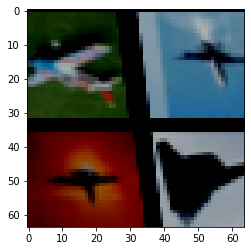

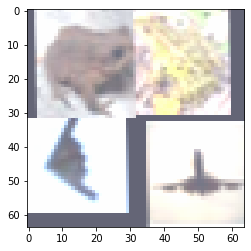

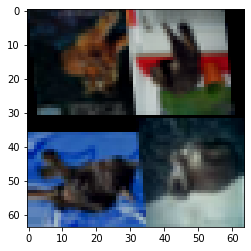

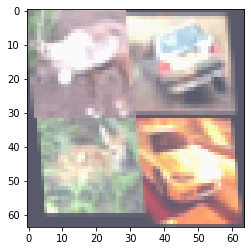

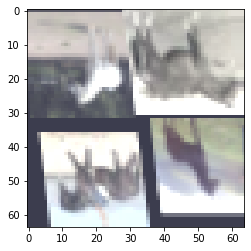

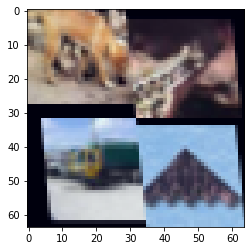

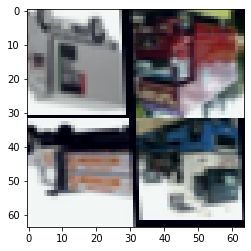

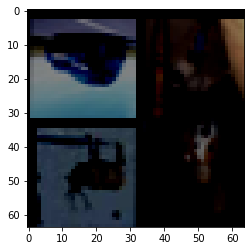

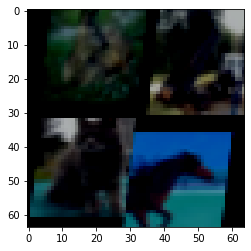

In [ ]:
x_batch, y_batch = next(train_datagen)
for i in range (0,9):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

# Training Models

## CNN

### Hyper-parameter tuning

In [ ]:
def build_model_cnn(hp):
    model=Sequential()
    model.add(Conv2D(kernel_size=(3,3), filters=32, input_shape=(64, 64, 3), padding='same', activation='relu'))
    model.add(Conv2D(kernel_size=(3,3), filters=32, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    #providing the range for hidden layers  
    for i in range(hp.Int('num_of_layers',1,2)):         
        #providing range for number of neurons in hidden layers
        model.add(Dense(units=hp.Int('num_of_neurons'+ str(i),min_value=32,max_value=512,step=32), activation='relu'))
    #output layer
    model.add(Dense(num_classes,activation='softmax'))

    #compiling the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [ ]:
def get_best_model(model_set, train_datagen, validate_datagen):
  model_set(keras_tuner.HyperParameters())
  tuner = keras_tuner.RandomSearch(
      hypermodel=model_set,
      objective="val_accuracy",
      max_trials=3,
      executions_per_trial=1,
      overwrite=True,
      directory="my_dir",
      project_name="image_class",
      )
  tuner.search_space_summary()

  # stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
  callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
               tensorflow.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

  tuner.search(train_datagen, epochs=3, validation_data=validate_datagen, callbacks=callbacks)
  tuner.results_summary()

  best_param_cnn = tuner.get_best_hyperparameters()[0].values

  best_model = tuner.get_best_models(num_models=1)[0]

  return best_model, best_param_cnn

In [ ]:
best_model_cnn, best_param_cnn = get_best_model(build_model_cnn, train_datagen, validate_datagen)

Trial 3 Complete [00h 03m 31s]
val_accuracy: 0.24940000474452972

Best val_accuracy So Far: 0.33693334460258484
Total elapsed time: 00h 10m 41s
Results summary
Results in my_dir/image_class
Showing 10 best trials
Trial summary
Hyperparameters:
num_of_layers: 2
num_of_neurons0: 288
learning_rate: 0.0001
num_of_neurons1: 32
Score: 0.33693334460258484
Trial summary
Hyperparameters:
num_of_layers: 2
num_of_neurons0: 352
learning_rate: 0.001
num_of_neurons1: 480
Score: 0.25093331933021545
Trial summary
Hyperparameters:
num_of_layers: 2
num_of_neurons0: 320
learning_rate: 0.01
num_of_neurons1: 64
Score: 0.24940000474452972


In [ ]:
best_param_cnn

{'num_of_layers': 2,
 'num_of_neurons0': 288,
 'learning_rate': 0.0001,
 'num_of_neurons1': 32}

### Train with best parameters

In [ ]:
def trian_best_model(best_model, train_datagen, validate_datagen, test_X, test_y):
  best_model.build(input_shape=(None,64,64,3))
  best_model.summary()

  # stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
  callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
               tensorflow.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

  history = best_model.fit_generator(
      generator=train_datagen,
      steps_per_epoch=len(train_datagen),
      validation_data=validate_datagen,
      epochs=15,
      callbacks=callbacks
      )
  
  score = best_model.evaluate(test_X, test_y, verbose=0)
  print("Test loss:", score[0])
  print("Test accuracy:", score[1])

  predictions = best_model.predict(test_X)
  # Convert possiblity as digit label
  pre = np.argmax(predictions, axis=1)

  return history, pre

In [ ]:
history_cnn, pre_cnn = trian_best_model(best_model_cnn, train_datagen, validate_datagen, test_X, test_y)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 288)               9437472   
                                                        

<ipython-input-26-a034e4a3d373>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = best_model.fit_generator(


1407/1407 [==============================] - 71s 50ms/step - loss: 1.3202 - accuracy: 0.3439 - val_loss: 1.3058 - val_accuracy: 0.3551
Epoch 2/15
1407/1407 [==============================] - 69s 49ms/step - loss: 1.3021 - accuracy: 0.3601 - val_loss: 1.2872 - val_accuracy: 0.3761
Epoch 3/15
1407/1407 [==============================] - 70s 50ms/step - loss: 1.2899 - accuracy: 0.3701 - val_loss: 1.3202 - val_accuracy: 0.3450
Epoch 4/15
1407/1407 [==============================] - 69s 49ms/step - loss: 1.2797 - accuracy: 0.3768 - val_loss: 1.2763 - val_accuracy: 0.3787
Epoch 5/15
1407/1407 [==============================] - 70s 50ms/step - loss: 1.2710 - accuracy: 0.3827 - val_loss: 1.2653 - val_accuracy: 0.3845
Epoch 6/15
1407/1407 [==============================] - 69s 49ms/step - loss: 1.2638 - accuracy: 0.3859 - val_loss: 1.2653 - val_accuracy: 0.3753
Epoch 7/15
1407/1407 [==============================] - 70s 50ms/step - loss: 1.2578 - accuracy: 0.3894 - val_loss: 1.2582 - val_accura

### Training & Validation: Loss and Accuracy

In [ ]:
def plot_loss_acc(history):
  # Training & Validation Loss
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  epochs = range(1, len(loss_values) + 1)

  plt.plot(epochs, loss_values, 'bo', label='Training loss') # blue dots
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # blue line
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

  # Training & Validation Accuracy
  plt.clf()
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

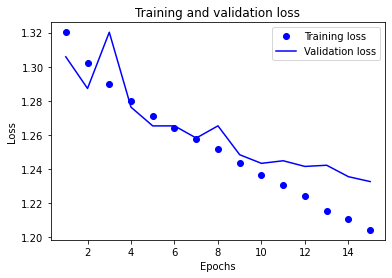

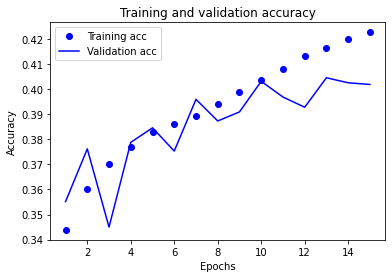

In [ ]:
plot_loss_acc(history_cnn)

### Confusion Matrix

In [ ]:
def plot_cm(pre, test_y):
  cm = confusion_matrix(np.argmax(test_y, axis=-1), pre)
  plt.figure()
  fig, ax = plot_confusion_matrix(cm, cmap=plt.cm.Blues)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

<Figure size 432x288 with 0 Axes>

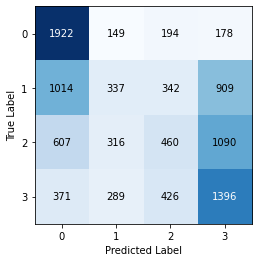

In [ ]:
plot_cm(pre_cnn, test_y)

## Resnet-50

### Hyper-parameter tuning

In [ ]:
def build_model_res50(hp):
  input_t = keras.Input(shape=(64, 64, 3))
  model = keras.Sequential()
  model.add(ResNet50(include_top=False, weights="imagenet", input_tensor=input_t))
  model.add(layers.Flatten())
  #providing the range for hidden layers
  for i in range(hp.Int('num_of_layers',1,2)):         
        #providing range for number of neurons in hidden layers
        model.add(Dense(units=hp.Int('num_of_neurons'+ str(i),min_value=32,max_value=512,step=32), activation='relu'))
  #output layer
  model.add(layers.Dense(num_classes, activation="softmax"))

  #compiling the model
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),loss='categorical_crossentropy',metrics=['accuracy'])
  
  return model

In [ ]:
best_model_res50, best_param_res50 = get_best_model(build_model_res50, train_datagen, validate_datagen)

Trial 3 Complete [00h 05m 20s]
val_accuracy: 0.4816666543483734

Best val_accuracy So Far: 0.4816666543483734
Total elapsed time: 00h 16m 30s
Results summary
Results in my_dir/image_class
Showing 10 best trials
Trial summary
Hyperparameters:
num_of_layers: 1
num_of_neurons0: 320
learning_rate: 0.0001
num_of_neurons1: 256
Score: 0.4816666543483734
Trial summary
Hyperparameters:
num_of_layers: 2
num_of_neurons0: 160
learning_rate: 0.0001
num_of_neurons1: 32
Score: 0.46860000491142273
Trial summary
Hyperparameters:
num_of_layers: 1
num_of_neurons0: 128
learning_rate: 0.01
Score: 0.2520666718482971


In [ ]:
best_param_res50

{'num_of_layers': 1,
 'num_of_neurons0': 320,
 'learning_rate': 0.0001,
 'num_of_neurons1': 256}

### Train with best parameters

In [ ]:
history_res50, pre_res50 = trian_best_model(best_model_res50, train_datagen, validate_datagen, test_X, test_y)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 320)               2621760   
                                                                 
 dense_1 (Dense)             (None, 4)                 1284      
                                                                 
Total params: 26,210,756
Trainable params: 26,157,636
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/15


<ipython-input-26-a034e4a3d373>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = best_model.fit_generator(


1407/1407 [==============================] - 108s 73ms/step - loss: 1.0788 - accuracy: 0.4931 - val_loss: 1.1044 - val_accuracy: 0.4901
Epoch 2/15
1407/1407 [==============================] - 102s 72ms/step - loss: 1.0342 - accuracy: 0.5210 - val_loss: 1.0822 - val_accuracy: 0.5074
Epoch 3/15
1407/1407 [==============================] - 102s 72ms/step - loss: 0.9907 - accuracy: 0.5462 - val_loss: 1.0119 - val_accuracy: 0.5423
Epoch 4/15
1407/1407 [==============================] - 102s 72ms/step - loss: 0.9523 - accuracy: 0.5628 - val_loss: 0.9781 - val_accuracy: 0.5674
Epoch 5/15
1407/1407 [==============================] - 102s 73ms/step - loss: 0.9157 - accuracy: 0.5852 - val_loss: 0.9173 - val_accuracy: 0.5949
Epoch 6/15
1407/1407 [==============================] - 102s 73ms/step - loss: 0.8756 - accuracy: 0.6071 - val_loss: 0.8884 - val_accuracy: 0.6050
Epoch 7/15
1407/1407 [==============================] - 102s 72ms/step - loss: 0.8460 - accuracy: 0.6202 - val_loss: 0.8637 - val

### Training & Validation: Loss and Accuracy

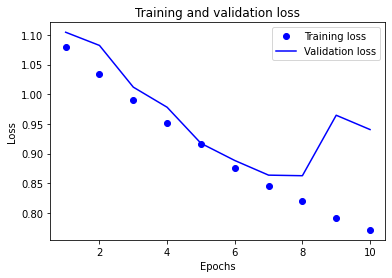

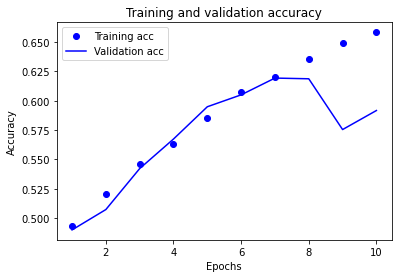

In [ ]:
plot_loss_acc(history_res50)

### Confusion Matrix

<Figure size 432x288 with 0 Axes>

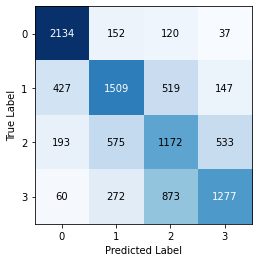

In [ ]:
plot_cm(pre_res50, test_y)